In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [111]:
# FUNÇÃO CRIADA PARA CRIAÇÃO DOS GRÁFICOS

def reg_graph (x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    
    sns.set_style('darkgrid')
    
    f, ax = plt.subplots(1,figsize=(8, 5))
    
    sns.scatterplot(x=data[x], y=data[y], data=data,size=sct_size)
    
    rng = np.random.default_rng(1234) #seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)   
    fitted_reg = lr.fit(data[[x]],data[[y]])
    
    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_] # Prevenindo erros
        
    r2_score = fitted_reg.score(data[[x]],data[[y]]) # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100) # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada
    
    if reg_from_start:
        x_reg_line = rng.uniform(0, 100 , size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada

    
    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  #eixo x do texto

    
    plt.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
    plt.text(text_coord_x, offset_txt_y - (offset_txt_y*0.3), f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²
    

    ax.set_ylim((0, (data[y].max() + 1))) # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + 1)) # tamanho limite do plot no eixo x
    ax.plot(x_reg_line,y_reg_line[0]) #reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 100, size=1000) # gerando 100 valores aleatórios 
        ax.plot(y_x,y_x, 'k--') # reta y=x
    

    
    plt.title(title) # Título do gráfico
    plt.legend(title=legend_title,loc='upper left').set_visible(legend_visibility) #legenda no canto superior esquerdo
    plt.xlabel(xlabel) #Título do eixo X
    plt.ylabel(ylabel) #Título do eixo y
    plt.tight_layout() #Redimensionar melhor o gráfico
    plt.show() #Mostrar o gráfico

In [112]:
ameriflux = pd.read_csv('./DadosNPPTorre/DADOS DE NPP - DADOS DE NPP.csv.csv') # Dados da AMERIFLUX
modis = pd.read_csv('./DadosNPPSatelite/Npp_500m.csv',header=None)

In [113]:
ameriflux = ameriflux.drop(['Time','Date'],axis=1)

ameriflux = ameriflux.apply(lambda x:pd.to_numeric(x,errors='coerce'))

ameriflux.fillna(np.nan)

ameriflux['NPP'] = ameriflux['NPP'].apply(lambda x: x/(10^6)) # umol m-2 y-1 / 10 ^ 6 = molCO2 m-2 y-1

ameriflux_npp = ameriflux.groupby(by='Year')['NPP'].mean() 

ameriflux_npp = ameriflux_npp * (12/44) # mol m-2 y-1  * g/mol = g m-2 y-1  # Relação massaC/massaCO2 pega do chatgpt

ameriflux_npp /= (10^3) # g m-2 y-1 / 10^3 = kgCO2 m-2 y-1

ameriflux_npp = ameriflux_npp.reset_index().drop('Year',axis=1)

ameriflux_npp *= -1 # Multipliquei por -1 para lidar apenas com valores positivos

ameriflux_npp

,NPP
0,1.225002
1,1.219483
2,1.274146


In [91]:
# profile = ProfileReport(ameriflux, tsmode=True,sortby="Year",title='Profile Report Ameriflux')
# profile.to_file("your_report.html")

In [114]:
def convert_unit(x):
    return x/10000



modis_data = modis.loc[modis[2].isin(['A2009001','A2010001','A2011001'])].copy() # Dados de NPP nos anos de 2009, 2010 e 2011


modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas


modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 


modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe


modis_data.apply(convert_unit) # Conversão para kgC/m²/year como está disposto no mapa (Adição de um 0 a mais para coincidir com o mapa do site)

modis_npp_mean = modis_data.apply(lambda x:x/10000).mean(axis=1) # Média de NPP nesses anos
modis_npp_mean

0
A2009001    1.204458
A2010001    1.183961
A2011001    1.227251
dtype: float64

In [115]:
npp_dataframe = {
    'ameriflux_NPP':ameriflux_npp.values.reshape(1,-1)[0],
    'modis_NPP':modis_npp_mean.values
}
npp_dataframe = pd.DataFrame(npp_dataframe)
npp_dataframe

,ameriflux_NPP,modis_NPP
0,1.225002,1.204458
1,1.219483,1.183961
2,1.274146,1.227251


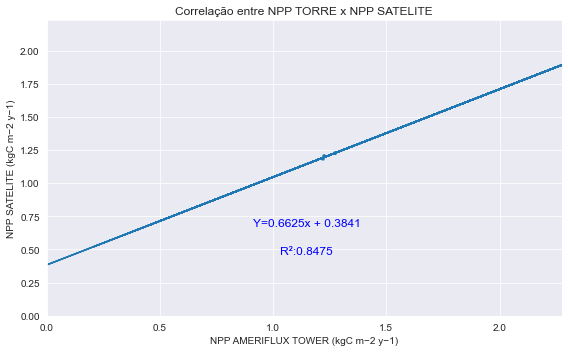

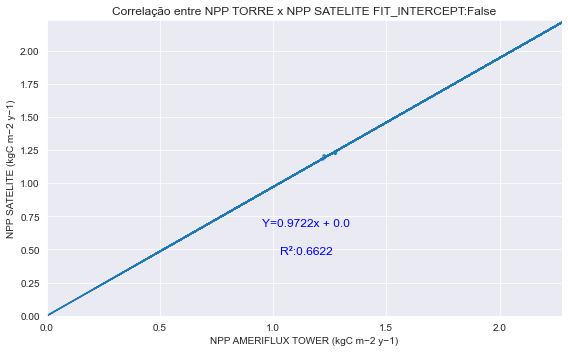

In [117]:
#(x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25)
eixo_x = 'ameriflux_NPP'
eixo_y = 'modis_NPP'
data = npp_dataframe
xlabel = "NPP AMERIFLUX TOWER (kgC m−2 y−1)"
ylabel = "NPP SATELITE (kgC m−2 y−1)"
title = "Correlação entre NPP TORRE x NPP SATELITE"

reg_graph(eixo_x,eixo_y,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=0.7)

reg_graph(eixo_x,eixo_y,data=data,xlabel=xlabel,ylabel=ylabel,title=title + ' FIT_INTERCEPT:False',fit_intercept=False,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=0.7)